# 02 Calculators

Many software packages can be used to calculate properties from a set of atomic positions. In ASE, Atoms objects can try to calculate or fetch properties using an attached "Calculator".

Here we make tour of a variety of Calculators, highlighting some of the differences between them. A master list of the available Calculators can be found [here](https://wiki.fysik.dtu.dk/ase/ase/calculators/calculators.html).

### In-built calculators: simple potential models (EMT, LJ)

Much of the ASE documentation and tutorials makes use of the [inbuilt "EMT" calculator](https://wiki.fysik.dtu.dk/ase/ase/calculators/emt.html#pure-python-emt-calculator) - because it is convenient and "fast enough"!

This implements the Effective Medium Theory potential for Ni, Cu, Pd, Ag, Pt and Au. Some other elements are included "for fun", but really this is a method for alloys of those metals. For more information see this documentation and references for the (more efficient) implementation in the ASAP code: https://wiki.fysik.dtu.dk/asap/EMT

Considering the case of an infinite gold wire:

In [1]:
from ase import Atoms
from ase.calculators.emt import EMT

def make_wire(spacing: float = 2.5,
              box_size: float = 10.0) -> Atoms:

    wire = Atoms('Au',
                 positions=[[0., box_size / 2, box_size / 2]],
                 cell=[spacing, box_size, box_size],
                 pbc=[True, False, False])
    return wire

atoms = make_wire()
atoms.calc = EMT()
energy = atoms.get_potential_energy()
print(f"Energy: {energy} eV")

Energy: 0.9910548478768826 eV


In [2]:
import nglview

def show(atoms: Atoms) -> None:    
    view = nglview.show_ase(atoms)
    if any(atoms.pbc):
        view.add_unitcell()
    return view

show(atoms)

NGLWidget()

**Question:** *Why did we need the parentheses () in the line* `atoms.calc = EMT()`*?*

What can we do with an energy? We could look at how it varies with the atom spacing and fit a model.

In [3]:
import numpy as np
distances = np.linspace(2., 3., 21)

def get_energy(spacing):
    atoms = make_wire(spacing=spacing)
    atoms.calc = EMT()
    return atoms.get_potential_energy()

energies = list(map(get_energy, distances))

(Python tip: if you need to apply a function to each element of some data, `map` can provide an elegant alternative to for-loops and list comprehensions!)

In [4]:
from numpy.polynomial import Polynomial
fit = Polynomial.fit(distances, energies, 3)
x = np.linspace(2., 3., 500)

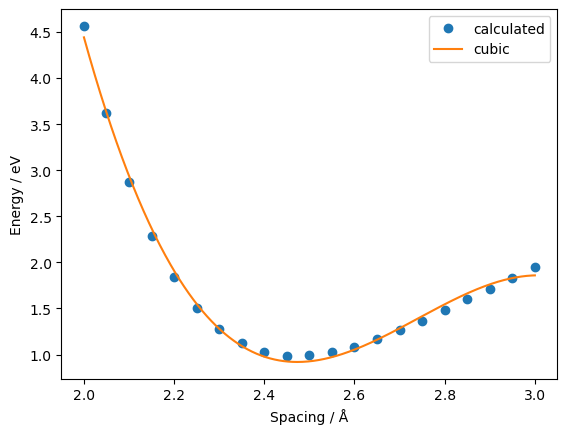

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
_ = ax.plot(distances, energies, 'o', label='calculated')
_ = ax.plot(x, fit(x), '-', label='cubic')
_ = ax.legend()
_ = ax.set_xlabel('Spacing / Å')
_ = ax.set_ylabel('Energy / eV')

This somewhat resembles the Equation-of-State (EOS) curve for a solid. To see how you can fit a standard EOS model to a 3-D system and obtain an equilibrium volume, see the relevant [ASE tutorial](https://wiki.fysik.dtu.dk/ase/tutorials/eos/eos.html).

The EMT Calculator can also be used to obtain forces and unit cell stress:

In [6]:
print("Forces: ")
print(atoms.get_forces())

print("Stress: ")
print(atoms.get_stress())

Forces: 
[[0. 0. 0.]]
Stress: 
[ 0.00396458 -0.         -0.         -0.         -0.         -0.        ]


**Question:** *why are the forces exactly zero for this system?*

Energy, forces and stress are standard "properties" in ASE, and we can check which properties are implemented by a particular calculator by inspecting the `implemented properties` attribute:

In [7]:
print(EMT.implemented_properties)

['energy', 'free_energy', 'energies', 'forces', 'stress', 'magmom', 'magmoms']


**Question:** why do we *not* need to include parenthesis () here? Do we expect `EMT().implemented_properties` to work as well as `EMT.implemented_properties`?

It can be convenient to have e.g. forces attached to a particular Atoms object in this way, and will be used heavily by dynamics and optimizer routines in the next tutorial.

However, for Open Science purposes it is easier to store and share data that is not connected to a Calculator. (As we shall see later, Calculators might depend on a particular machine environment, memory state or software license.) We can request a standalone set of property data with e.g.:

In [8]:
properties = atoms.get_properties(['energy', 'forces', 'stress'])
print(properties)

(Properties({'energy': 0.9910548478768826, 'natoms': 1, 'energies': array([0.99105485]), 'free_energy': 0.9910548478768826, 'forces': array([[0., 0., 0.]]), 'stress': array([ 0.00396458, -0.        , -0.        , -0.        , -0.        ,
       -0.        ])})


This will not change even if the Atoms object is modified and properties are recalculated.

> Warning: This is a new feature and does not yet work well for all calculators.

#### Lennard-Jones

The classic [Lennard-Jones potential](https://en.wikipedia.org/wiki/Lennard-Jones_potential) is implemented in `ase.calculators.lj`. You can set the $\epsilon$ and $\sigma$ parameters in the Calculator constructor:

In [9]:
from ase.calculators.lj import LennardJones

l = 4.1
atoms = Atoms('Xe2',
              positions=[[0., 0., -l / 2],
                         [0., 0., l / 2]],
              pbc=False)
atoms.calc = LennardJones(sigma=(4.1 / 2**(1/6)))

atoms.get_forces()
                           

array([[ 0.00000000e+00,  0.00000000e+00, -6.49886649e-16],
       [ 0.00000000e+00,  0.00000000e+00,  6.49886649e-16]])

**Question:** *Why are the forces so low at this geometry?*

**Exercise:** Try choosing a value of sigma and varying the distance between the atoms. Can you reproduce the classic plot of a Lennard-Jones binding curve?

## File-based calculators

Typically academic codes are controlled by _input files_ and write their results to _output files_. This workflow is convenient for batch calculations on clusters (and for Fortran programmers...)

For such a code, the ASE Calculator needs to prepare appropriate input, call the executable and then read the output in order to give a similar workflow to the inbuilt Calculator above.

#### MOPAC
Here we look at [MOPAC](https://openmopac.github.io), which implements semi-empirical methods with molecular orbitals in open boundary conditions. After a long history of versions and licenses it was recently updated and made open-source under the LGPL.

In [10]:
import ase.build
atoms = ase.build.molecule('C2H6CHOH')
show(atoms)

NGLWidget()

In [11]:
from ase.calculators.mopac import MOPAC
atoms.calc = MOPAC(label='isopropyl-alcohol')
print("Energy: ", atoms.get_potential_energy())



          MOPAC Job: "isopropyl-alcohol.mop" ended normally on Apr  3, 2023, at 21:29.

Energy:  -2.7842547352472047


We got an energy. Some data was also written to the Calculator `results`.

In [12]:
atoms.calc.results

{'version': 'v22.0.6',
 'final_hof': -2.7842547352472047,
 'total_energy': -772.22396,
 'forces': array([[ 0.09452837, -0.58935651,  0.32936589],
        [-0.08600234,  0.14274349,  0.18579394],
        [ 0.07639485,  0.31559567, -0.11416446],
        [ 0.04624326,  0.38071862,  0.42829993],
        [-0.0548457 , -0.0925792 , -0.20465619],
        [ 0.1883473 ,  0.10008969, -0.12176805],
        [-0.20786882, -0.0372329 , -0.15859723],
        [ 0.15218576, -0.10221587, -0.13990335],
        [-0.20513693,  0.04222415, -0.04563994],
        [ 0.06881428, -0.05719803, -0.06499095],
        [-0.10723496, -0.05249259, -0.0346418 ],
        [ 0.03457494, -0.05029646, -0.05909764]]),
 'dipole': array([ 0.23963168, -0.26607236,  0.20049114]),
 'energy': -2.7842547352472047,
 'free_energy': -2.7842547352472047}

*(This is one of the calculators that doesn't support get_properties() yet... We can still get a nice results container this way, though!)*

How did it do that? When we requested the potential energy, the Calculator generated an input file using the name we provided as *label*: "ispropyl-alcohol.mop". This is a human-readable file: take a look at it.

The top line includes some parameters for the calculation:
> PM7 1SCF GRADIENTS DISP RELSCF=0.0001 

including selection of the PM7 semi-empirical method and convergence tolerance. Below that are the atomic positions.

After writing the input, the calculation is run by calling the `mopac` executable: this should already be installed on the virtual machine for this tutorial.

The results were written to "isopropyl-alcohol.out"; this is another human-readable file.

**Exercise:** can you find the energy and forces in this file? Do they agree with the values from ASE?

*Hint: ASE mostly uses units related to eV and Ångström*

Next, we request the Forces:

In [13]:
print(atoms.get_forces())

[[ 0.09452837 -0.58935651  0.32936589]
 [-0.08600234  0.14274349  0.18579394]
 [ 0.07639485  0.31559567 -0.11416446]
 [ 0.04624326  0.38071862  0.42829993]
 [-0.0548457  -0.0925792  -0.20465619]
 [ 0.1883473   0.10008969 -0.12176805]
 [-0.20786882 -0.0372329  -0.15859723]
 [ 0.15218576 -0.10221587 -0.13990335]
 [-0.20513693  0.04222415 -0.04563994]
 [ 0.06881428 -0.05719803 -0.06499095]
 [-0.10723496 -0.05249259 -0.0346418 ]
 [ 0.03457494 -0.05029646 -0.05909764]]


This should give the results instantly: no new calculation was required! The Calculator object cached the results of the first calculation, and as forces were already present they are simply retrieved from the cache. This means we can mostly use the property getters without worrying about wastefully running unnecessary calculations.

In [14]:
atoms.calc.set(method='AM1')
atoms.get_potential_energy()



          MOPAC Job: "isopropyl-alcohol.mop" ended normally on Apr  3, 2023, at 21:29.



-2.8723671252448977

After changing a parameter (in this case, selecting the AM1 semi-empirical scheme) the cache is invalidated. When the potential energy is requested, a new calculation is performed.

**Question:** *what happens to calc.results when a parameter is changed? When might we prefer to use atoms.get_forces() vs atoms.calc.results['forces']?*

## External library calculators

Some calculators are not packaged with ASE, but included in some other package. For example, the `quippy` package provides a Python interface to a range of interatomic and tight-binding potentials. Here we apply a machine-learning-based potential for Si.

The documentation for Gaussian Approximation Potentials (GAP) links to a few published GAP models: https://libatoms.github.io/GAP/data.html
Follow the "Si" link and download the *Si_PRX_GAP.zip* file containing the model and training data. Move the .zip file somewhere you can find and extract the files.

*N.B. This requires a version of quippy that includes GAP. At the moment, `pip install` seems to work better than installing from conda-forge.*

In [16]:
from pathlib import Path
from quippy.potential import Potential

gap = Potential(param_filename=str(Path.cwd() / 'Si_PRX_GAP/gp_iter6_sparse9k.xml'))

Let's build a Si supercell and apply a random walk to the positions:

Text(0, 0.5, 'Energy / eV')

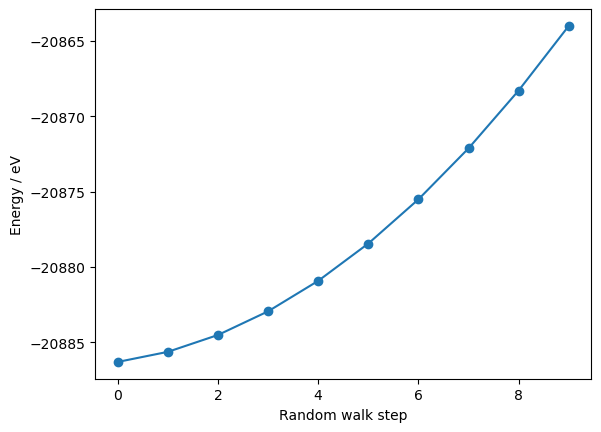

In [20]:
si = ase.build.bulk('Si') * 4
si.calc = gap

energies = []
for _ in range(10):
    si.rattle(stdev=0.01)
    energies.append(si.get_potential_energy())

fig, ax = plt.subplots()
ax.plot(energies, 'o-')
ax.set_xlabel('Random walk step')
ax.set_ylabel('Energy / eV')

This is a bit more expensive than EMT but still a lot cheaper than density-functional theory! A lot of work goes into developing a new potential, but with tools like quippy and ASE it is fairly easy for researchers to pick up the resulting model and apply it.

## Calculators using a parallel interpreter

GPAW is a bit special! It is an electronic structure code implemented as a Python library with C backend, and GPAW development is closely related to ASE development.

The difference between GPAW and other external Python calculators is that it includes a special Python interpreter for parallel calculations.

TODO:
- GPAW run in notebook using xc and kpts arguments
- time the run
- create a script file with equivalent settings and 4-way kpt parallelism
- compare runtime running on 4 cores

In [27]:
from ase.utils.timing import timer
timer?

Init signature: timer(name)
Docstring:     
Decorator for timing a method call.

Example::

    from ase.utils.timing import timer, Timer

    class A:
        def __init__(self):
            self.timer = Timer()

        @timer('Add two numbers')
        def add(self, x, y):
            return x + y

    
File:           ~/src/ase/ase/utils/timing.py
Type:           type
Subclasses:     

To begin with, we run a single-point energy calculation using Kohn-Sham density-functional theory (DFT).
- `xc` sets the exchange-correlation functional
- `kpts` sets the Brillouin-zone sampling
- `mode` sets the basis set; in this case a 400 eV cutoff plane-wave basis is used.

For more information about valid parameters, [see the GPAW docs](https://wiki.fysik.dtu.dk/gpaw/documentation/basic.html#parameters).

In [49]:
from gpaw import GPAW, PW

atoms = ase.build.bulk('Cu')
atoms.calc = GPAW(xc='PBE', kpts=(3, 3, 3), mode=PW(400))
energy = atoms.get_potential_energy()
print(energy)


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  22.8.0
 |___|_|             

User:   adam@Arctopus
Date:   Tue Apr  4 11:30:25 2023
Arch:   x86_64
Pid:    97252
CWD:    /home/adam/src/ase-tutorial-2023/development
Python: 3.10.0
gpaw:   /home/adam/.conda/envs/user-base/envs/ase-tutorials/lib/python3.10/site-packages/gpaw
_gpaw:  /home/adam/.conda/envs/user-base/envs/ase-tutorials/lib/python3.10/site-packages/
        _gpaw.cpython-310-x86_64-linux-gnu.so
ase:    /home/adam/src/ase/ase (version 3.23.0b1-70eab133b6)
numpy:  /home/adam/.conda/envs/user-base/envs/ase-tutorials/lib/python3.10/site-packages/numpy (version 1.23.5)
scipy:  /home/adam/.conda/envs/user-base/envs/ase-tutorials/lib/python3.10/site-packages/scipy (version 1.10.1)
libxc:  5.2.3
units:  Angstrom and eV
cores: 1
OpenMP: True
OMP_NUM_THREADS: 1

Input parameters:
  kpts: [3 3 3]
  mode: {ecut: 400.0,
         name: pw}
  xc: PBE

System changes: positions, numbers, cell, pbc, i

We should check the convergence of the energy with respect to k-point sampling. As well as accepting a simple mesh as e.g. `[3, 3, 3]`, we can pass a dictionary specification that generates a more specific mesh. In this case, we will shift the meshes to be off the Gamma-point.

We will also collect some timing information to understand how this impacts calculation cost. The output is directed to a text file to avoid cluttering our notebook.

This will take a few minutes to run: to see live output, open a terminal and use `tail -f kpts_serial.txt` to see this file grow. When it is finished, you can exit `tail` with ctrl-c.

In [50]:
from ase.utils.timing import Timer
timer = Timer()
energies, times, nkpts = [], [], []


for k in range(3,9):
    atoms.calc = GPAW(mode=PW(400), xc='PBE',
                      kpts={'size': [k, k, k],
                            'gamma': False},
                      txt='kpts_serial.txt')
    timer.start(str(k))
    energies.append(atoms.get_potential_energy())
    timer.stop(str(k))
    times.append(timer.get_time(str(k)))
    nkpts.append(len(atoms.calc.get_ibz_k_points()))


Timing:                              incl.     excl.
-----------------------------------------------------------
Hamiltonian:                         0.096     0.000   0.0% |
 Atomic:                             0.088     0.001   0.0% |
  XC Correction:                     0.087     0.087   0.8% |
 Calculate atomic Hamiltonians:      0.001     0.001   0.0% |
 Communicate:                        0.000     0.000   0.0% |
 Initialize Hamiltonian:             0.000     0.000   0.0% |
 Poisson:                            0.000     0.000   0.0% |
 XC 3D grid:                         0.007     0.007   0.1% |
LCAO initialization:                 0.344     0.082   0.7% |
 LCAO eigensolver:                   0.147     0.000   0.0% |
  Calculate projections:             0.000     0.000   0.0% |
  DenseAtomicCorrection:             0.000     0.000   0.0% |
  Distribute overlap matrix:         0.000     0.000   0.0% |
  Orbital Layouts:                   0.001     0.001   0.0% |
  Potential matrix:

Text(0.5, 0, 'number of k-points')

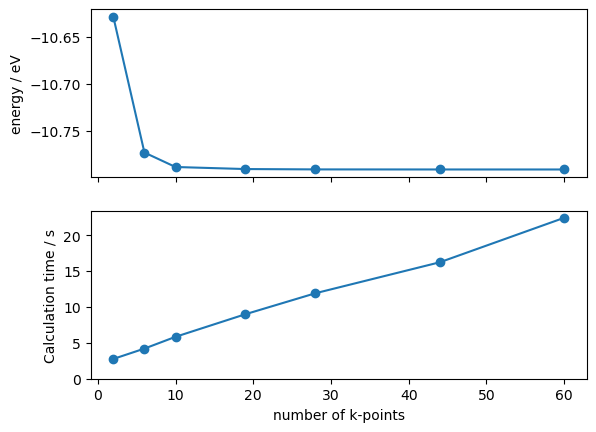

In [47]:
fig, axes = plt.subplots(nrows=2, sharex=True)
axes[0].plot(nkpts, energies, 'o-')
axes[0].set_ylabel('energy / eV') 
axes[1].plot(nkpts, times, 'o-')
axes[1].set_ylabel('Calculation time / s')
axes[1].set_ylim([0, None])
axes[1].set_xlabel('number of k-points')

For this calculation, the computational cost per k-point is roughly linear, but the energy convergence is slow. We have multiple cores available, but how do we use them?

Create a script file with the following code, named "kpts_parallel.py"

```
from gpaw import GPAW, PW

import ase.build
from ase.parallel import parprint, world, paropen
from ase.utils.timing import Timer
import json

print("Hello from every process!")
parprint("Hello from one process!")

atoms = ase.build.bulk('Cu')

timer = Timer()
energies, times, nkpts = [], [], []

for k in range(3, 9):
    atoms.calc = GPAW(mode=PW(400), xc='PBE',
                      kpts={'size': [k, k, k],
                            'gamma': False},
                      txt='kpts_parallel.txt',
                      parallel={'kpt': True})
    timer.start(str(k))
  
    energy = atoms.get_potential_energy()
    
    timer.stop(str(k))
    energies.append(energy)
    times.append(timer.get_time(str(k)))
    nkpts.append(len(atoms.calc.get_ibz_k_points()))

with paropen('parallel_results.json', 'w') as fd:
    json.dump({'energies': energies,
               'times': times,
               'nkpts': nkpts},
              fd)

```

Run the script from the command-line with
```
gpaw -P 4 python kpts_parallel.py
```

where `gpaw python` runs a special Python interpreter and the `-P 4` option runs this over 4 MPI tasks.

Text(0.5, 0, 'number of k-points')

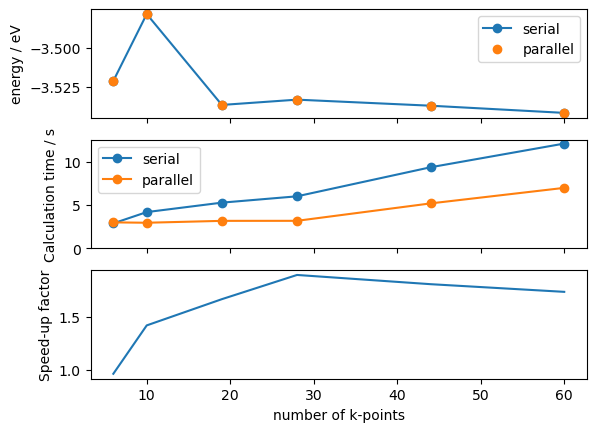

In [56]:
import json
with open('parallel_results.json', 'r') as fd:
    parallel_data = json.load(fd)

fig, axes = plt.subplots(nrows=3, sharex=True)
axes[0].plot(nkpts, energies, 'o-', label='serial')
axes[0].plot(parallel_data['nkpts'], parallel_data['energies'], 'o', label='parallel')
axes[0].set_ylabel('energy / eV')
axes[0].legend()

axes[1].plot(nkpts, times, 'o-', label='serial')
axes[1].plot(parallel_data['nkpts'], parallel_data['times'], 'o-', label='parallel')
axes[1].set_ylabel('Calculation time / s')
axes[1].legend()
axes[1].set_ylim([0, None])

axes[2].plot(nkpts, np.asarray(times) / parallel_data['times'], label='4 cores')
axes[2].set_ylabel('Speed-up factor')
axes[2].set_xlabel('number of k-points')

Hopefully, running in parallel did not change the results! We see that the parallel calculation is faster, but not 4 times faster.

The parallel Python process essentially runs 4 copies of the script. The GPAW part is smart enough to coordinate, but the copied processes can become obvious when we do things like `print`, and can cause data corruption when multiple processes try to write to the same file. `parprint` and `paropen` are provided in ASE to handle these common cases: for other scenarios it may be necessary to use logic with `ase.parallel.world`. For more information see the relevant [GPAW docs](https://wiki.fysik.dtu.dk/gpaw/documentation/parallel_runs/parallel_runs.html) and [ASE docs](https://wiki.fysik.dtu.dk/ase/ase/parallel.html)

## Espresso

Maybe not used here yet, use to show more advanced calculations, band structure etc.

In [ ]:
from pathlib import Path
# Customise to espresso pseudopotential path
pseudo_dir = str(
    Path.home() / 'opt/espresso_sssp/SSSP_1.1.2_PBE_efficiency')

calc = Espresso(pseudo_dir=pseudo_dir, kpts=(3, 3, 3),
                tprnfor=True, tstress=True, # enable stress/force calc
                pseudopotentials={'Si': 'Si.pbe-n-rrkjus_psl.1.0.0.UPF'})